
<h2><center>Проект: cWGAN, cVAE</center></h2>

In [137]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [138]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("data/magic04.data", header=None)
data.columns = names
data.head()

,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Постановка задачи

Я решу задачу генерации параметров кластеров с изображений телескопа для каждого типа частиц (фотон или адрон) с помощью условных генеративно-состязательных сетей (cGAN).

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [139]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [140]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [141]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

# Визуализация данных

Каждое изображение описывается 10 параметрами

In [142]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(4 * 4, 4 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.hist(X1[:, i], bins=bins, alpha=0.5, label=label1, color="C0")
        plt.hist(X2[:, i], bins=bins, alpha=0.5, label=label2, color="C1")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

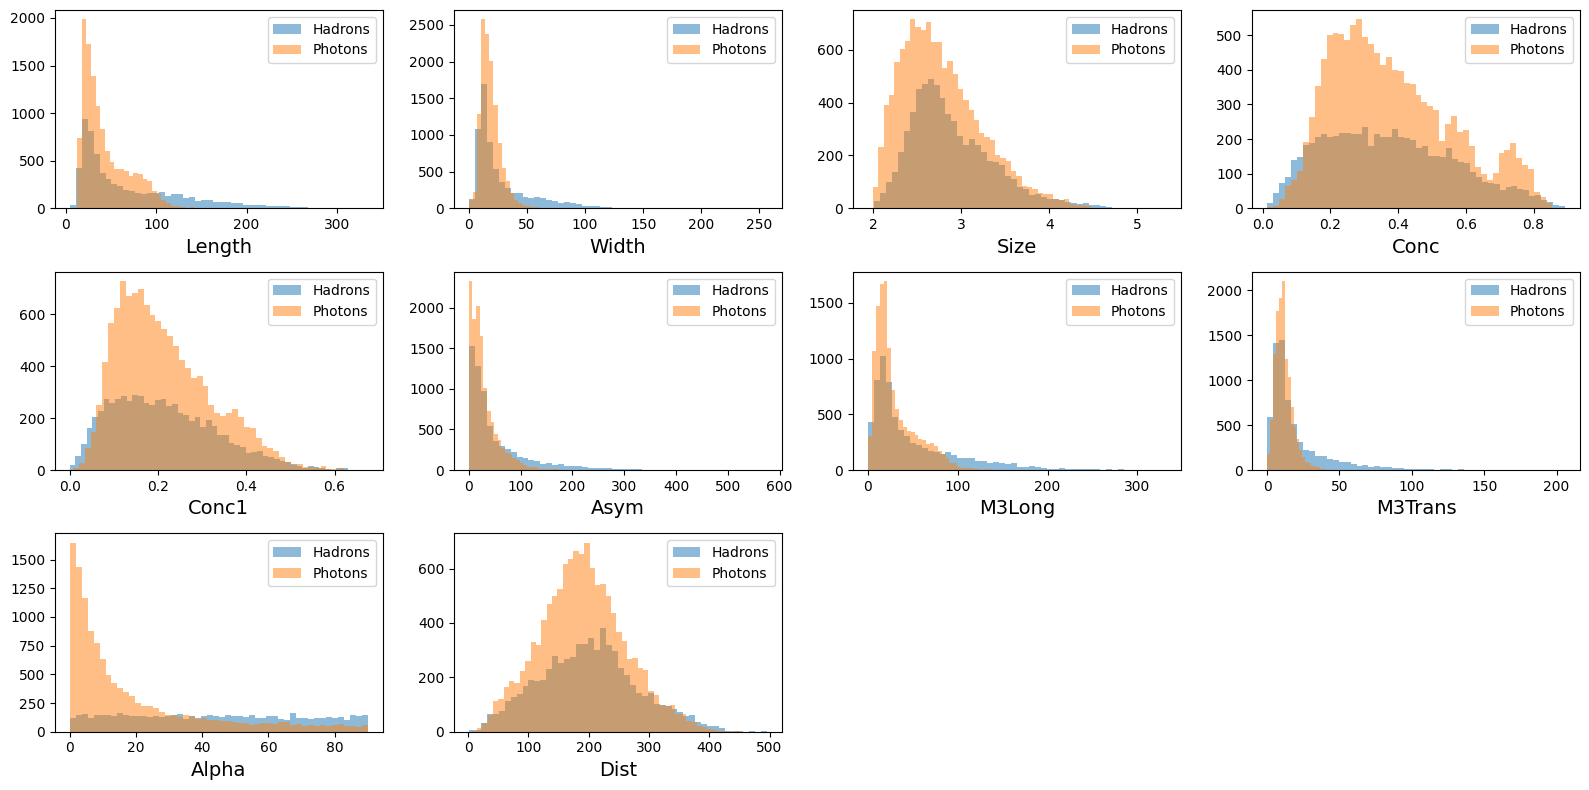

In [143]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому, нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты. 

Я применю QuantileTransformer из sklearn.preprocessing к входным данным X, установив параметр output_distribution='normal', чтобы привести распределение каждого признака к приближённо нормальному виду.

In [144]:
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(output_distribution='normal', random_state=0)

X_qt = qt.fit_transform(X)

In [155]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_qt)

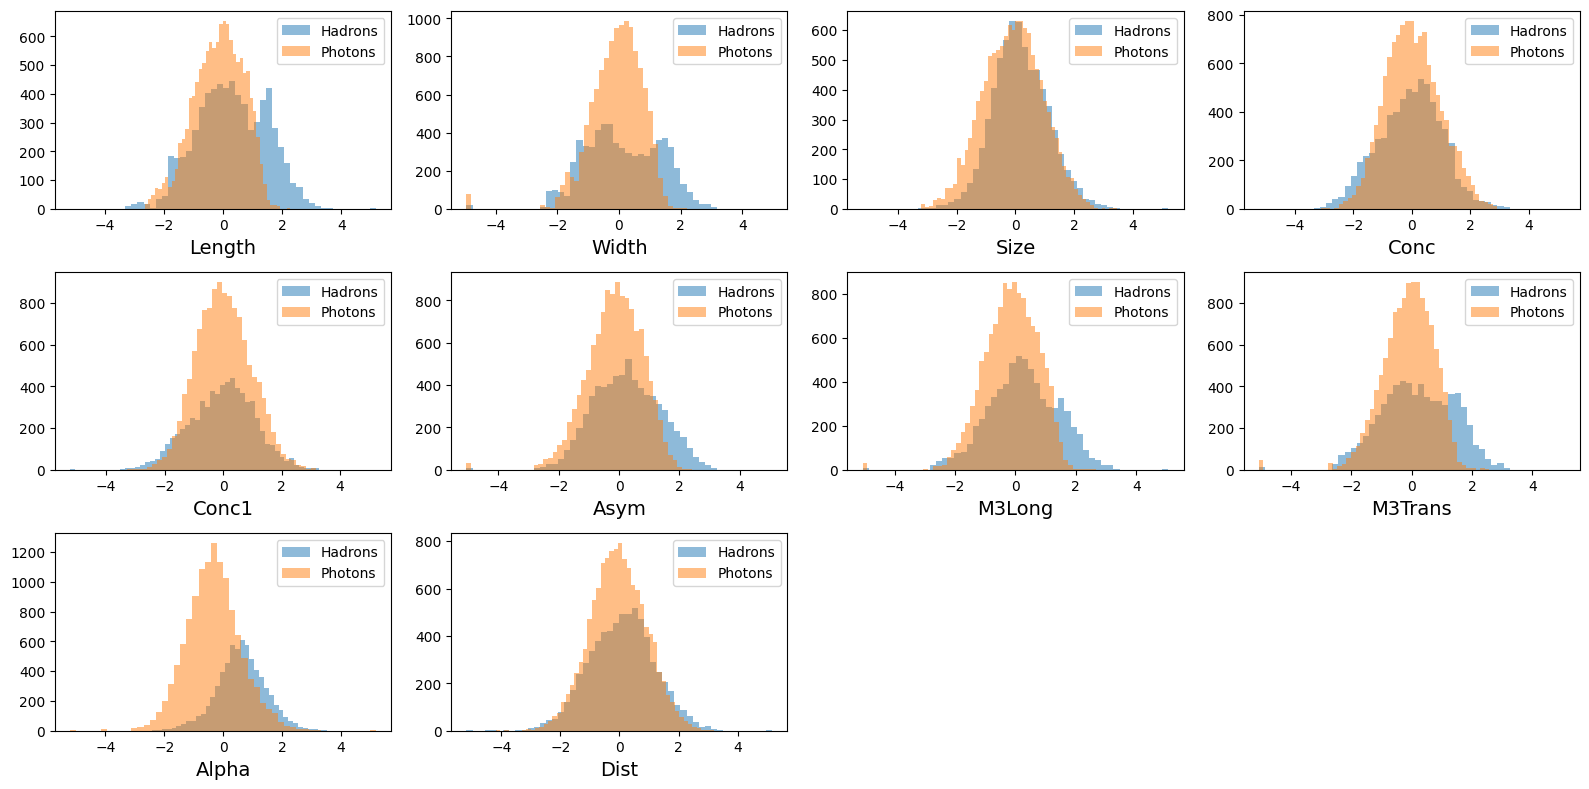

In [156]:
plot_hists(
    X_scaled[y[:, 0] == 0],
    X_scaled[y[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

# Обучающая и тестовая выборки

In [157]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, stratify=y, test_size=0.5, shuffle=True, random_state=11
)

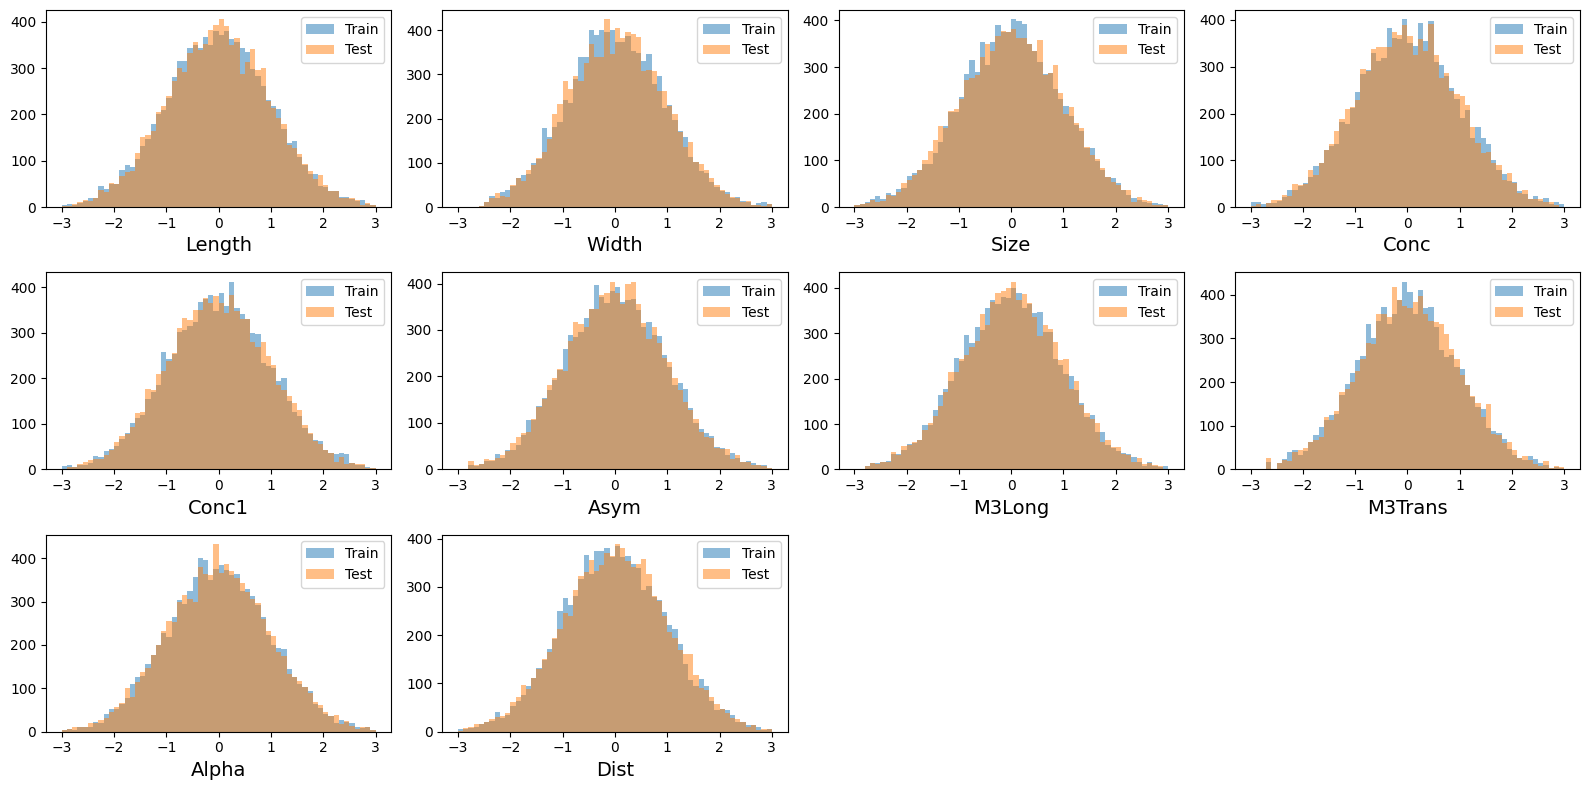

In [158]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Conditional WGAN

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$. 

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + -\frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

`pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118`

In [159]:
#Проверка
import torch

print("CUDA доступна:", torch.cuda.is_available())
print("Версия CUDA:", torch.version.cuda)


CUDA доступна: True
Версия CUDA: 11.8


In [160]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [161]:
DEVICE

device(type='cuda')

Я реализую генератор в виде нейронной сети с помощью nn.Sequential, включив следующие слои:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [163]:
class Generator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()
        
        self.net =  nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs)
        )

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return self.net(zy)

Я реализую нейронную сеть для дискриминатора, последовательно добавив указанные слои в соответствии с заданной архитектурой:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

In [164]:
class Discriminator(nn.Module):
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )
       

    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        return self.net(xy)

Реализую класс для обучения генеративной модели.

In [ ]:
class Fitter(object):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):

        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)

        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):
                real_batch = real_batch.to(DEVICE)
                cond_batch = cond_batch.to(DEVICE)
                batch_size = real_batch.size(0)
                
                z = torch.normal(0, 1, size=(batch_size, self.latent_dim), device=DEVICE)
                for _ in range(self.n_critic):
                    self.opt_disc.zero_grad()

                    d_real = self.discriminator(real_batch, cond_batch)
                    fake_batch = self.generator(z, cond_batch)
                    d_fake = self.discriminator(fake_batch.detach(), cond_batch)

                    loss_disc = torch.mean(d_fake) - torch.mean(d_real)
                    loss_disc.backward()
                    self.opt_disc.step()

                    for p in self.discriminator.parameters():
                        p.data.clamp_(-0.01, 0.01)

                self.opt_gen.zero_grad()

                z = torch.normal(0, 1, size=(batch_size, self.latent_dim), device=DEVICE)
                fake_batch = self.generator(z, cond_batch)
                d_fake = self.discriminator(fake_batch, cond_batch)

                loss_gen = -torch.mean(d_fake)
                loss_gen.backward()
                self.opt_gen.step()

            # caiculate and store loss after an epoch
            Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim), device=DEVICE)
            X_fake = self.generator(Z_noise, y_cond)
            loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(
                self.discriminator(X_fake, y_cond)
            )
            self.loss_history.append(loss_epoch.detach().cpu())

        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)

        # Проверка, что все работает на GPU
        print(next(self.generator.parameters()).device)      
        print(next(self.discriminator.parameters()).device)   
        print(X_real.device, y_cond.device)                  
        print(real_batch.device, cond_batch.device)          
        print(Z_noise.device) 
        print("\n")                               

## Обучение
Обучим модель на данных.

In [175]:
%%time
latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1] + y.shape[1])

fitter = Fitter(
    generator,
    discriminator,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
fitter.fit(X_train, y_train)

cuda:0
cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0


CPU times: total: 3min 50s
Wall time: 4min 10s


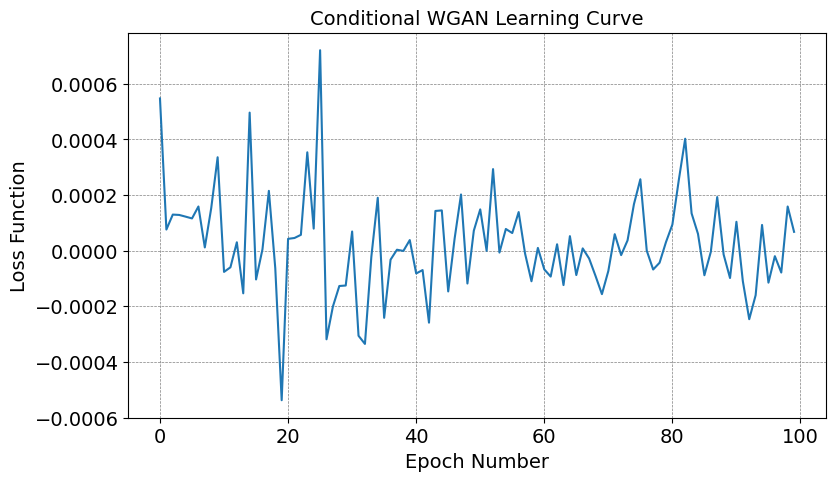

In [178]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.grid(True, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

Реализую функцию для генерации новый объектов $X$ по вектору условий $y$.

In [180]:
def generate(generator, y, latent_dim):
    generator.eval()
    if not isinstance(y, torch.Tensor):
        y_tensor = torch.tensor(y, dtype=torch.long, device=DEVICE)
    else:
        y_tensor = y.to(DEVICE)
    z = torch.randn(y_tensor.shape[0], latent_dim, device=DEVICE)

    with torch.no_grad():
        fake = generator(z, y_tensor)      
    X_fake = fake.cpu().numpy()

    return X_fake 

Теперь сгенерирую фейковые матрицы `X_fake_train` и `X_fake_test`. Сравню их с матрицами реальных объектов `X_train` и `X_test`

In [182]:
X_fake_train = generate(fitter.generator, y_train, latent_dim)

Реальные точки и фейковые находятся в разных диапазонах. Нужно преобазовать фэйковые данные

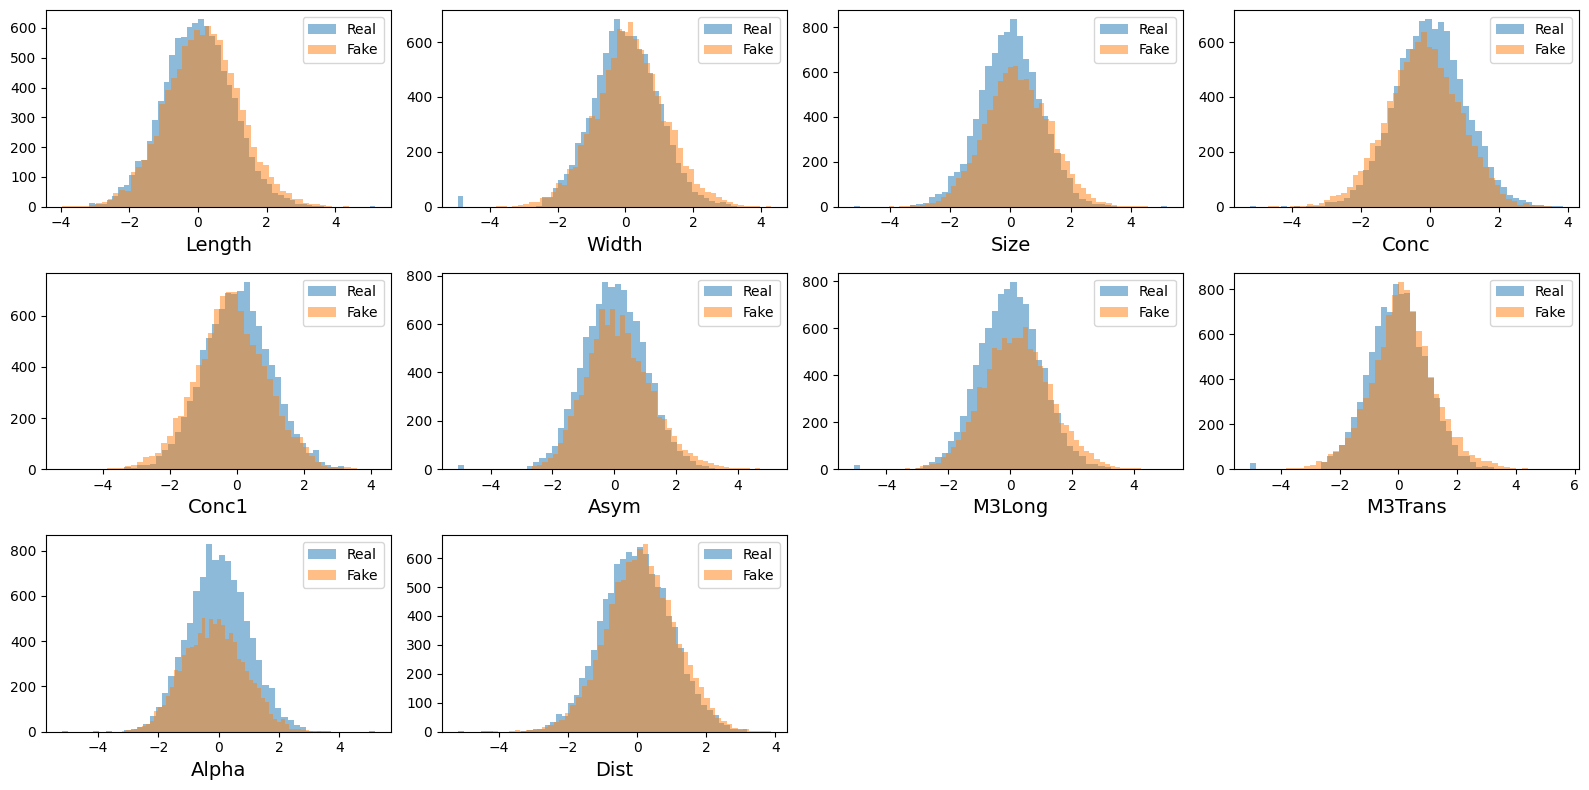

In [183]:
plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

In [184]:
X_fake_test = generate(fitter.generator, y_test, latent_dim)

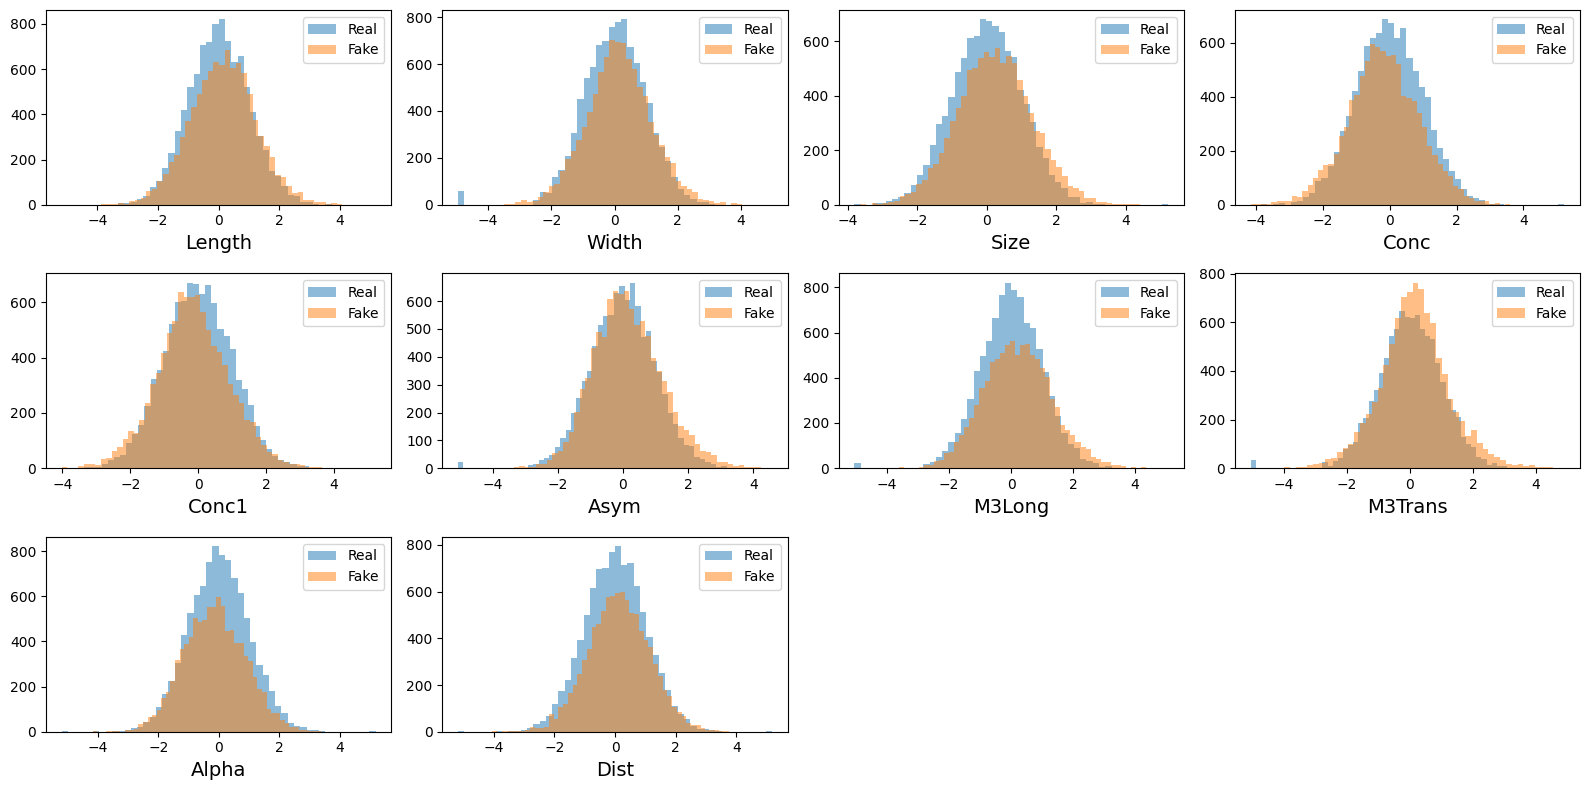

In [185]:
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

## Вывод 1: 
Визуально мы видим сходство реальных и фейковых данных. Однако это только проекции 10-мерных объектов на одну ось.

# Измерение качества генерации

Измерим сходство распределений классификатором.

In [186]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [187]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [188]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.7354122839315747


## Вывод 2

Идеальное значение ROC AUC равно 0.5. Это соответствует случаю, когда классификатор не может разделить реальные и фейковые данные. В нашем случае ROC AUC около 0.7, что говорит о том, что есть куда улучшать качество генеративной модели 

# Условные вариационные автокодировщики

Теперь, решу эту же задачу используя условный автокодировщик (CVAE).

Я реализую нейронную сеть для декодеровщика со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой для mu; Выходной слой для log_sigma;

In [189]:
class Encoder(nn.Module):
    def __init__(self, n_inputs, lat_size):
        super(Encoder, self).__init__()

        self.enc_net = nn.Sequential(
            nn.Linear(n_inputs, 100),  
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU()
        )

        self.mu = nn.Linear(100, lat_size)
        self.log_sigma = nn.Linear(100, lat_size)

    def forward(self, x, y):
        z = torch.cat((x, y), dim=1)
        z = self.enc_net(z)
        mu = self.mu(z)
        log_sigma = self.log_sigma(z)
        return mu, log_sigma

Нейронная сеть для декодеровщика со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

In [190]:
class Decoder(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Decoder, self).__init__()

        self.dec_net = nn.Sequential(
            nn.Linear(n_inputs, 100), 
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, n_outputs)
        )

    def forward(self, z, y):
        z_cond = torch.cat((z, y), dim=1)
        x_rec = self.dec_net(z_cond)
        return x_rec

Класс для обучения вариационного автокодировщика.

In [ ]:
class VAEFitter(object):
    def __init__(
        self,
        encoder,
        decoder,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        KL_weight=0.001,
    ):

        self.encoder = encoder
        self.decoder = decoder
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.KL_weight = KL_weight

        self.criterion = nn.MSELoss()
        self.opt = torch.optim.RMSprop(
            list(self.encoder.parameters()) + list(self.decoder.parameters()),
            lr=self.lr,
        )

        self.encoder.to(DEVICE)
        self.decoder.to(DEVICE)

    def sample_z(self, mu, log_sigma):
        eps = torch.randn(mu.shape).to(DEVICE)
        return mu + torch.exp(log_sigma / 2) * eps

    def custom_loss(self, x, rec_x, mu, log_sigma):
        KL = torch.mean(
            -0.5 * torch.sum(1 + log_sigma - mu**2 - log_sigma.exp(), dim=1), dim=0
        )
        recon_loss = self.criterion(x, rec_x)
        return KL * self.KL_weight + recon_loss

    def compute_loss(self, x_batch, cond_batch):

        mu, log_sigma = self.encoder(x_batch, cond_batch)
        z = self.sample_z(mu, log_sigma)
        rec_x = self.decoder(z, cond_batch)
        loss = self.custom_loss(x_batch, rec_x, mu, log_sigma)

        return loss

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.encoder.train(True)
        self.decoder.train(True)

        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            for i, (x_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                # caiculate loss
                loss = self.compute_loss(x_batch, cond_batch)

                # optimization step
                self.opt.zero_grad()
                loss.backward()
                self.opt.step()

            # caiculate and store loss after an epoch
            loss_epoch = self.compute_loss(X_real, y_cond)
            self.loss_history.append(loss_epoch.detach().cpu())

        # Turn off training
        self.encoder.train(False)
        self.decoder.train(False)

        print(next(self.encoder.parameters()).device)      
        print(next(self.decoder.parameters()).device)   
        print(X_real.device, y_cond.device)                  
        print(x_batch.device, cond_batch.device)          
        print("\n") 

## Обучение

In [192]:
%%time

latent_dim = 10

encoder = Encoder(n_inputs=X_train.shape[1] + y.shape[1], lat_size=latent_dim)
decoder = Decoder(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])

vae_fitter = VAEFitter(
    encoder,
    decoder,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.001,
    KL_weight=0.001,
)
vae_fitter.fit(X_train, y_train)

cuda:0
cuda:0
cuda:0 cuda:0
cuda:0 cuda:0


CPU times: total: 1min 1s
Wall time: 1min 2s


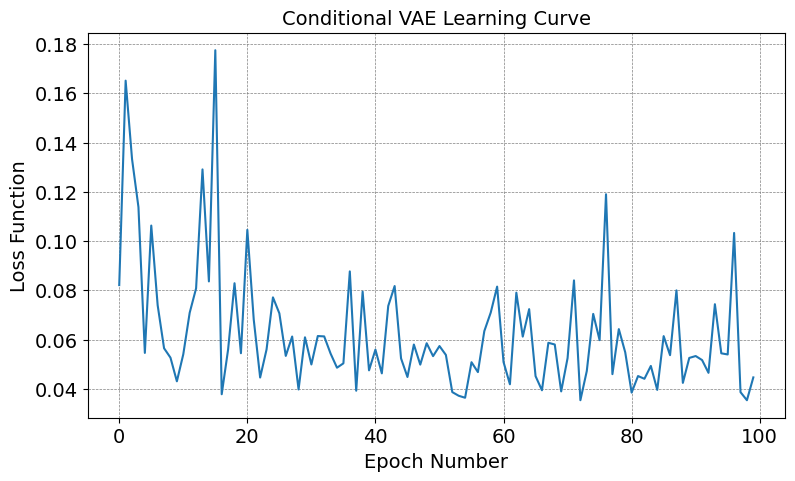

In [194]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(vae_fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional VAE Learning Curve", size=14)
plt.grid(True, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

Функция для генерации новый объектов $X$ по вектору условий $y$.

In [195]:
def generate(decoder, y, latent_dim):
    y_tensor = torch.tensor(y, dtype=torch.float, device=DEVICE)
    z = torch.randn(y_tensor.shape[0], latent_dim, device=DEVICE)
    X_fake = decoder(z, y_tensor)

    X_fake = X_fake.detach().cpu().numpy()
    
    return X_fake  # numpy

Генерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`

In [196]:
X_fake_train = generate(vae_fitter.decoder, y_train, latent_dim)

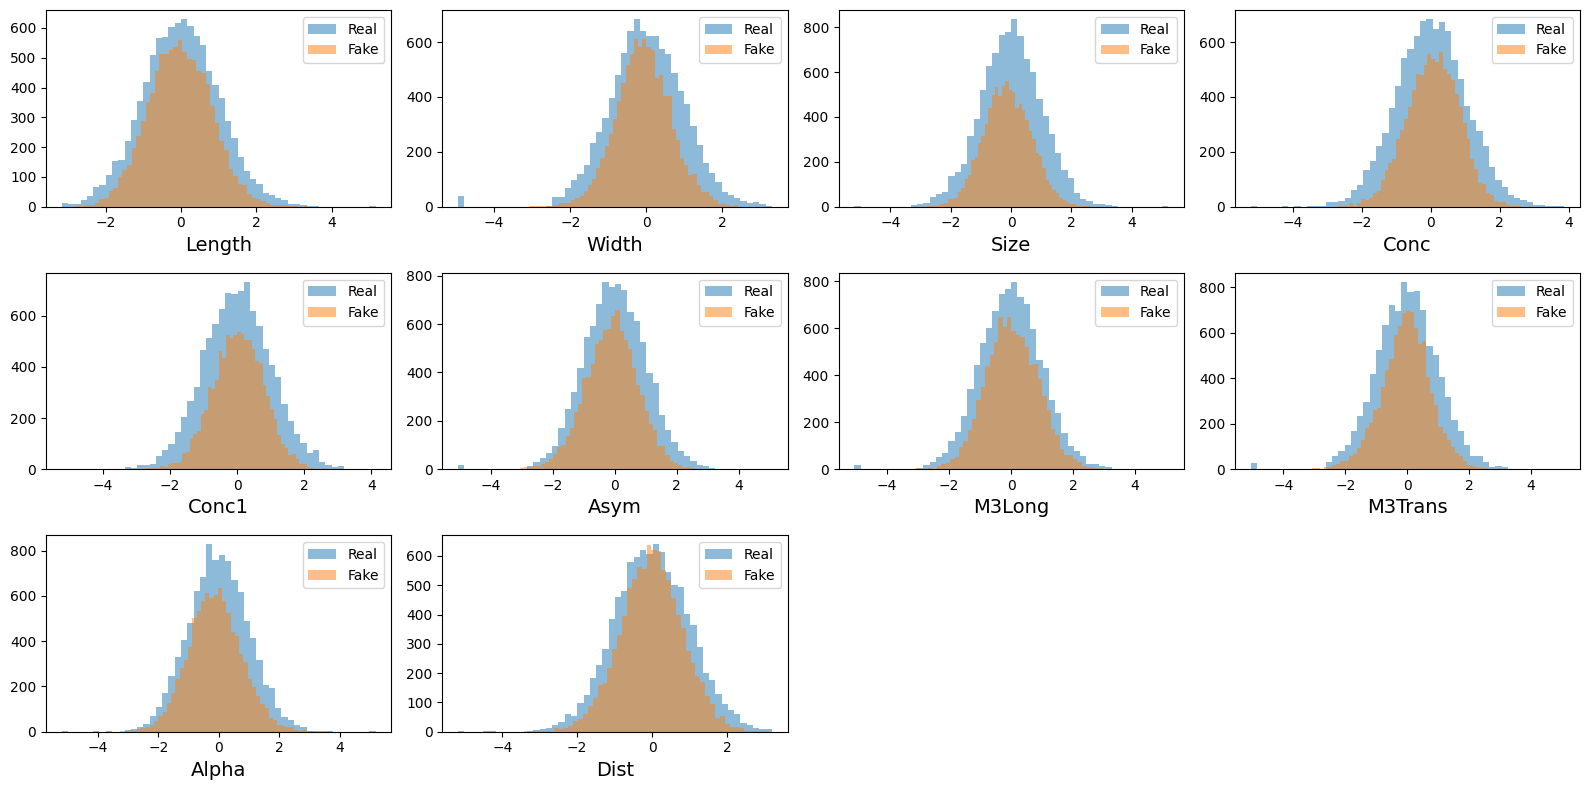

In [197]:
plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

In [198]:
X_fake_test = generate(vae_fitter.decoder, y_test, latent_dim)

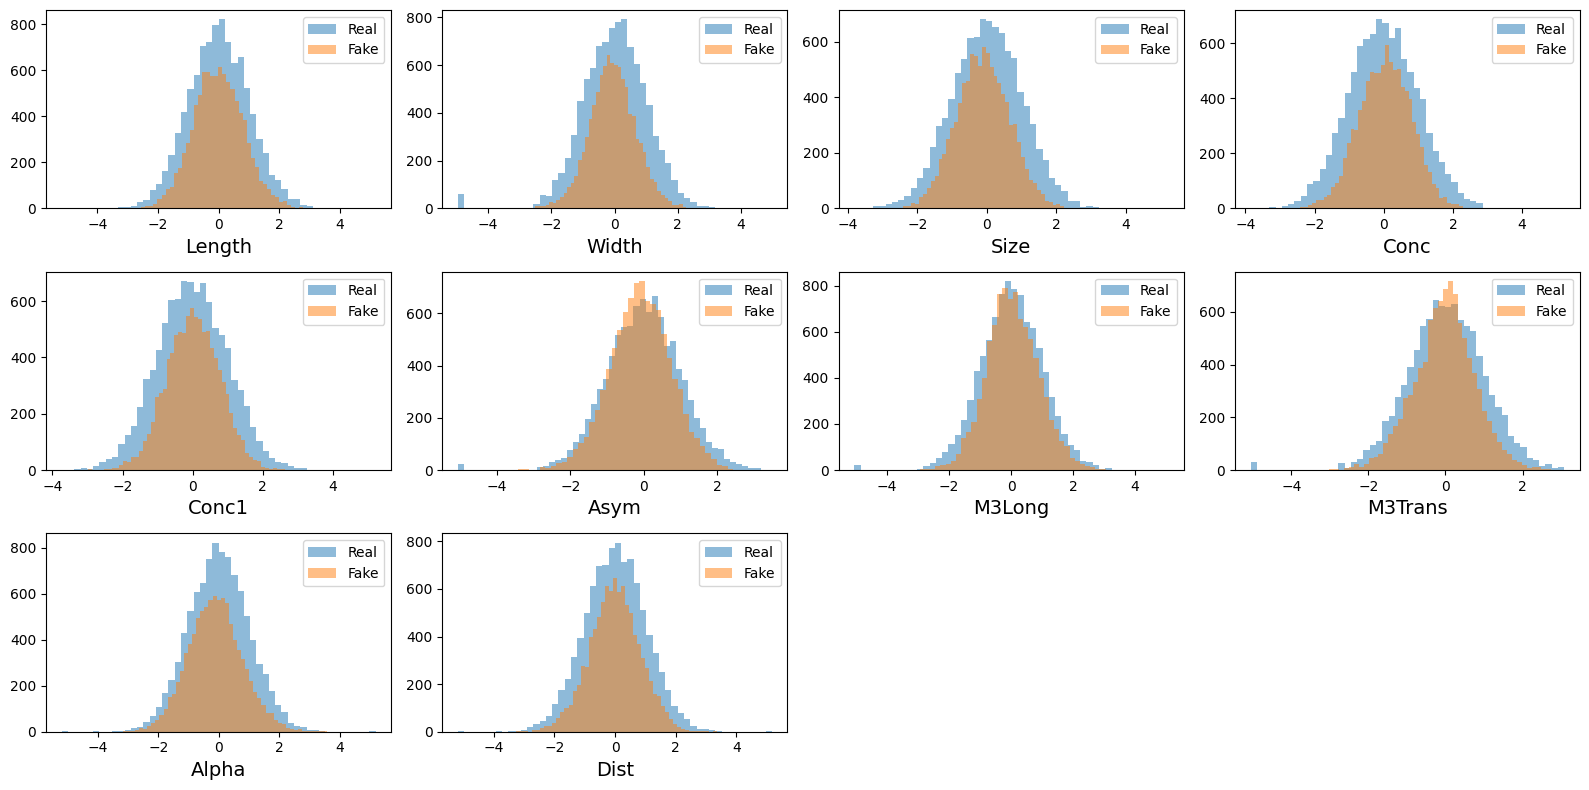

In [199]:
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

# Измерение качества генерации

In [200]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [201]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [202]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.7144733641382528


## Вывод 3

Для CVAE получили ROC AUC около 0.7 (меньше лучше). Таким образом видим, что в данной задаче обе модели ведут себя схожим образом